In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

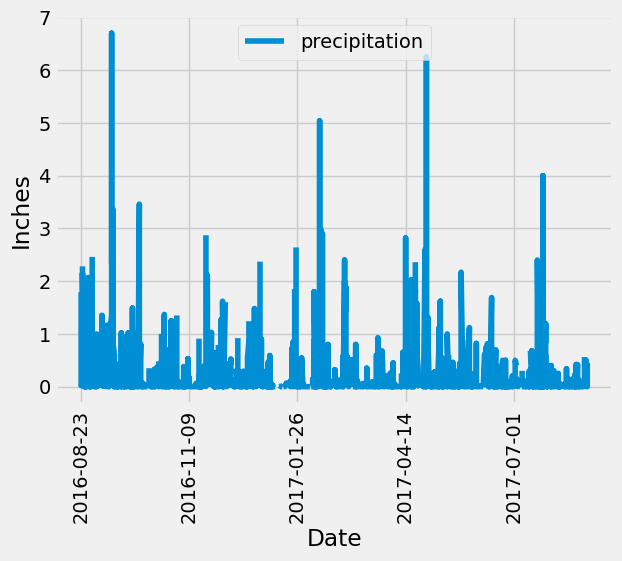

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_dt = session.query(measurement).order_by(measurement.date.desc()).first().date
# Calculate the date one year from the last date in data set.
year_ago_dt = dt.datetime.fromisoformat(most_recent_dt) - dt.timedelta(days=365)
# need to remove 00:00:00 timestamp from saved year_ago_dt because SQLite does not have Date types, only String comparisons
year_ago_dt = year_ago_dt.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
select = [measurement.date, measurement.prcp]
query = session.query(*select).where(measurement.date >= year_ago_dt)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
past_yr_precip_df = pd.DataFrame(query, columns=['date', 'precipitation'])

# Sort the dataframe by date
past_yr_precip_df = past_yr_precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(past_yr_precip_df['date'], past_yr_precip_df['precipitation'], label='precipitation')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc='upper center')
plt.xticks(np.arange(0,365,365/5+5), rotation=90);

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
past_yr_precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(measurement.station).distinct().count()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc()).all()
# because stations are ordered from highest to least count, most_active is the first entry
most_active_station = active_stations[0][0]
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
select = [func.min(measurement.tobs),
          func.max(measurement.tobs),
          func.avg(measurement.tobs)]
tobs_agg = session.query(*select).where(measurement.station==most_active_station).all()
tobs_agg

[(54.0, 85.0, 71.66378066378067)]

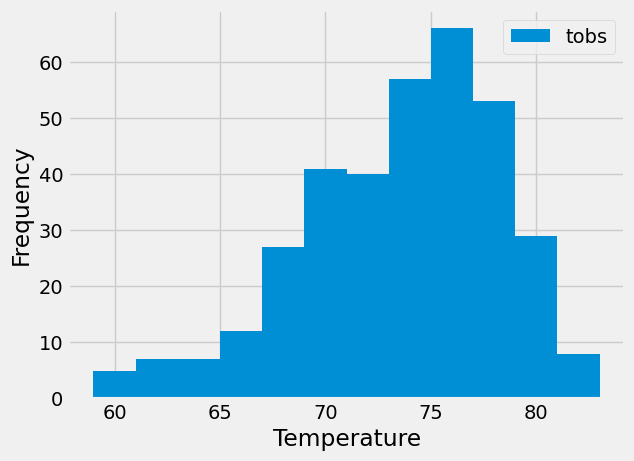

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
select = [measurement.date, measurement.tobs]
last_yr_qry = session.query(*select).where(measurement.station==most_active_station)\
    .where(measurement.date >= year_ago_dt)
last_yr_df = pd.DataFrame(last_yr_qry, columns=['date', 'temperature'])
plt.hist(last_yr_df['temperature'], bins=12, label='tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc='upper right');

# Close Session

In [16]:
# Close Session
session.close()